### Logistic Regression with TensorFlow

In [1]:
# Import necessary libraries

import tensorflow as tf
import pandas as pd
import numpy as np
import time
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
print(tf.__version__)

2.12.0


<h3>Understanding the Data</h3>

<h4><code>Iris Dataset</code>:</h4>
This dataset was introduced by British Statistician and Biologist Ronald Fisher, it consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). In total it has 150 records under five attributes - petal length, petal width, sepal length, sepal width and species. <a href="https://archive.ics.uci.edu/ml/datasets/iris?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0120ENSkillsNetwork954-2022-01-01">Dataset source</a>

Attributes
Independent Variable

<ul>
    <li>petal length</li>
    <li>petal width</li>
    <li>sepal length</li>
    <li>sepal width</li>
</ul>
Dependent Variable
<ul>    
    <li>Species
        <ul>
            <li>Iris setosa</li>
            <li>Iris virginica</li>
            <li>Iris versicolor</li>
        </ul>
    </li>
</ul>
<br>


In [4]:
iris = load_iris()
iris_X, iris_y = iris.data[:-1,:], iris.target[:-1]
iris_y= pd.get_dummies(iris_y).values
trainX, testX, trainY, testY = train_test_split(iris_X, iris_y, test_size=0.33, random_state=42)

Now we define x and y. These variables will hold our iris data (both the features and label matrices) We also need to give them shapes which correspond to the shape of our data. 


In [5]:
# numFeatures is the number of features in our input data.
# In the iris dataset, this number is '4'.
numFeatures = trainX.shape[1]
print('numFeatures is : ', numFeatures )
# numLabels is the number of classes our data points can be in.
# In the iris dataset, this number is '3'.
numLabels = trainY.shape[1]
print('numLabels is : ', numLabels )

#X = tf.Variable( np.identity(numFeatures), tf.TensorShape(numFeatures),dtype='float32') # Iris has 4 features, so X is a tensor to hold our data.
#yGold = tf.Variable(np.array([1,1,1]),shape=tf.TensorShape(numLabels),dtype='float32') # This will be our correct answers matrix for 3 classes.

numFeatures is :  4
numLabels is :  3


In [6]:
trainX = tf.constant(trainX, dtype='float32')
trainY = tf.constant(trainY, dtype='float32')
testX = tf.constant(testX, dtype='float32')
testY = tf.constant(testY, dtype='float32')

<h3>Set model weights and bias</h3>

Much like Linear Regression, we need a shared variable weight matrix for Logistic Regression. We initialize both <code>W</code> and <code>b</code> as tensors full of zeros. Since we are going to learn <code>W</code> and <code>b</code>, their initial value does not matter too much. These variables are the objects which define the structure of our regression model, and we can save them after they have been trained so we can reuse them later.

We define two TensorFlow variables as our parameters. These variables will hold the weights and biases of our logistic regression and they will be continually updated during training. 

Notice that <code>W</code> has a shape of [4, 3] because we want to multiply the 4-dimensional input vectors by it to produce 3-dimensional vectors of evidence for the difference classes. <code>b</code> has a shape of [3] so we can add it to the output. TensorFlow variables need to be initialized with values, e.g. with zeros.


In [7]:
W = tf.Variable(tf.zeros([4, 3]))  # 4-dimensional input and  3 classes
b = tf.Variable(tf.zeros([3])) # 3-dimensional output [0,0,1],[0,1,0],[1,0,0]

In [8]:
#Randomly sample from a normal distribution with standard deviation .01

weights = tf.Variable(tf.random.normal([numFeatures,numLabels],
                                       mean=0.,
                                       stddev=0.01,
                                       name="weights"),dtype='float32')


bias = tf.Variable(tf.random.normal([1,numLabels],
                                    mean=0.,
                                    stddev=0.01,
                                    name="bias"))


<h3>Logistic Regression model</h3>

We now define our operations in order to properly run the Logistic Regression. Logistic regression is typically thought of as a single equation:

$$
ŷ =sigmoid(WX+b)
$$

However, for the sake of clarity, we can have it broken into its three main components: 

-   a weight times features matrix multiplication operation, 
-   a summation of the weighted features and a bias term, 
-   and finally the application of a sigmoid function. 

As such, you will find these components defined as three separate operations below.


In [9]:
# Three-component breakdown of the Logistic Regression equation.
# Note that these feed into each other.
def logistic_regression(x):
    apply_weights_OP = tf.matmul(x, weights, name="apply_weights")
    add_bias_OP = tf.add(apply_weights_OP, bias, name="add_bias") 
    activation_OP = tf.nn.sigmoid(add_bias_OP, name="activation")
    return activation_OP

As we have seen before, the function we are going to use is the <i>logistic function</i> $(\frac{1}{1+e^{-Wx}})$, which is fed the input data after applying weights and bias. In TensorFlow, this function is implemented as the <code>nn.sigmoid</code> function. Effectively, this fits the weighted input with bias into a 0-100 percent curve, which is the probability function we want.


<hr>


<a id="ref3"></a>

<h2>Training</h2>

The learning algorithm is how we search for the best weight vector (${\\\\bf w}$). This search is an optimization problem looking for the hypothesis that optimizes an error/cost measure.

<b>What tells us that our model is bad?</b>  
The Cost or Loss of the model, so what we want is to minimize that. 

<h3>Cost function</h3>
Before defining our cost function, we need to define how long we are going to train and how should we define the learning rate.


In [10]:
# Number of Epochs in our training
numEpochs = 700

# Defining our learning rate iterations (decay)
learningRate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0008,
                                          decay_steps=trainX.shape[0],
                                          decay_rate= 0.95,
                                          staircase=True)

<b>What is the cost function in our model?</b>  
The cost function we are going to utilize is the Squared Mean Error loss function.

<b>How to minimize the cost function?</b>  
We can't use <b>least-squares linear regression</b> here, so we will use <a href="http://en.wikipedia.org/wiki/Gradient_descent?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0120ENSkillsNetwork954-2022-01-01">gradient descent</a> instead. Specifically, we will use batch gradient descent which calculates the gradient from all data points in the data set.


In [11]:
#Defining our cost function - Squared Mean Error
loss_object = tf.keras.losses.MeanSquaredLogarithmicError()
optimizer = tf.keras.optimizers.SGD(learningRate)

We also want some additional operations to keep track of our model's efficiency over time. We can do this like so:


In [12]:
# Accuracy metric.
def accuracy(y_pred, y_true):
# Predicted class is the index of the highest score in prediction vector (i.e. argmax).

    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))

    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

We first wrap computation inside a GradientTape for automatic differentiation. Then we compute gradients and update W and b.


In [13]:
# Optimization process. 

def run_optimization(x, y):
    with tf.GradientTape() as g:
        pred = logistic_regression(x)
        loss = loss_object(pred, y)
    gradients = g.gradient(loss, [weights, bias])
    optimizer.apply_gradients(zip(gradients, [weights, bias]))

Now we move on to actually running our operations. We will start with the operations involved in the prediction phase (i.e. the logistic regression itself).


Now we can define and run the actual training loop, like this:


In [14]:
# Initialize reporting variables
display_step = 10
epoch_values = []
accuracy_values = []
loss_values = []
loss = 0
diff = 1
# Training epochs
for i in range(numEpochs):
    if i > 1 and diff < .0001:
        print("change in loss %g; convergence."%diff)
        break
    else:
        # Run training step
        run_optimization(trainX, trainY)
        
        # Report occasional stats
        if i % display_step == 0:
            # Add epoch to epoch_values
            epoch_values.append(i)
            
            pred = logistic_regression(testX)

            newLoss = loss_object(pred, testY)
            # Add loss to live graphing variable
            loss_values.append(newLoss)
            
            # Generate accuracy stats on test data
            acc = accuracy(pred, testY)
            accuracy_values.append(acc)
            
    
            # Re-assign values for variables
            diff = abs(newLoss - loss)
            loss = newLoss

            #generate print statements
            print("step %d, training accuracy %g, loss %g, change in loss %g"%(i, acc, newLoss, diff))

        

          

# How well do we perform on held-out test data?
print("final accuracy on test set: %s" %acc.numpy())




step 0, training accuracy 0.3, loss 0.136123, change in loss 0.136123
step 10, training accuracy 0.3, loss 0.135548, change in loss 0.000575274
step 20, training accuracy 0.3, loss 0.13498, change in loss 0.000567675
step 30, training accuracy 0.3, loss 0.13442, change in loss 0.000560045
step 40, training accuracy 0.3, loss 0.133868, change in loss 0.000552401
step 50, training accuracy 0.3, loss 0.133323, change in loss 0.000544757
step 60, training accuracy 0.3, loss 0.132786, change in loss 0.000537038
step 70, training accuracy 0.3, loss 0.132257, change in loss 0.000529349
step 80, training accuracy 0.3, loss 0.131735, change in loss 0.000521645
step 90, training accuracy 0.3, loss 0.131221, change in loss 0.000513956
step 100, training accuracy 0.3, loss 0.13072, change in loss 0.000501215
step 110, training accuracy 0.3, loss 0.130246, change in loss 0.000473887
step 120, training accuracy 0.3, loss 0.129779, change in loss 0.000466987
step 130, training accuracy 0.3, loss 0.12

<b>Why don't we plot the loss to see how it behaves?</b>


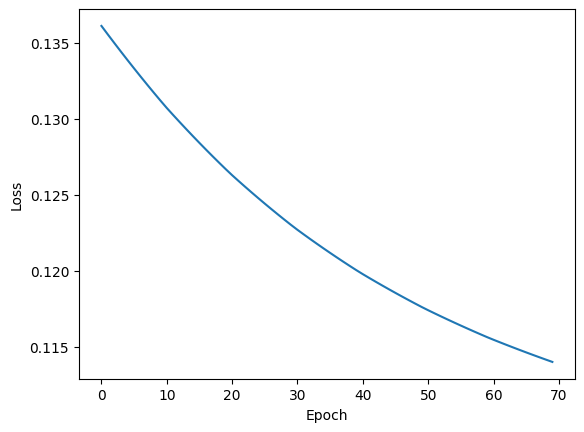

In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(loss_values)
plt.show()